In [23]:
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf

from keras import layers
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.datasets import fashion_mnist
from keras.callbacks import History, Callback

In [24]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.clf()
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [25]:
def plot_precision_recall(history):
    precision_values = [history.history[f'precision_class_{i}'][-1] for i in range(9)]
    recall_values = [history.history[f'recall_class_{i}'][-1] for i in range(9)]

    classes = [str(i) for i in range(9)]
    width = 0.35
    x = range(len(classes))

    plt.figure(figsize=(12, 6))

    plt.bar(x, precision_values, width, label='Precision')
    plt.bar([i + width for i in x], recall_values, width, label='Recall')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall for Each Class')
    plt.xticks([i + width/2 for i in x], classes)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.grid(axis='y', linestyle='--')

    plt.show()

In [26]:
clothing_classes = 10

In [27]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

train_data, test_data = train_data / 255., test_data / 255.

mask_train_remove_6 = train_labels != 6
mask_test_remove_6 = test_labels != 6

train_data = train_data[mask_train_remove_6]
train_labels = train_labels[mask_train_remove_6]

test_data = test_data[mask_test_remove_6]
test_labels = test_labels[mask_test_remove_6]

train_labels = np.where(train_labels == 9, 6, train_labels)
test_labels = np.where(test_labels == 9, 6, test_labels)

train_labels_one_hot = to_categorical(train_labels, num_classes=clothing_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=clothing_classes)

In [28]:
precision_per_class = [Precision(class_id=i, name=f'precision_class_{i}') for i in range(clothing_classes)]
recall_per_class = [Recall(class_id=i, name=f'recall_class_{i}') for i in range(clothing_classes)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

In [29]:
class MyFilterModelMP(keras_tuner.HyperModel):
  def build(self, hp):
    model = Sequential([
      Conv2D(
          filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
          kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
          activation='relu',
          input_shape=(28,28,1)
      ),
      MaxPooling2D((2, 2)),
      Conv2D(
          filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
          kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
          activation='relu'
      ),
      Flatten(),
      Dense(
          units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
          activation='relu'
      ),
      Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='categorical_crossentropy',
                metrics=all_metrics)

    return model

  def fit(self, hp, model, x, y, validation_data, **kwargs):
    if hp.Boolean("normalize"):
      x = layers.Normalization()(x)
    return model.fit(
      x,
      y,
      validation_data=validation_data,
      shuffle=hp.Boolean("shuffle"),
      **kwargs,)

In [30]:
tuner = keras_tuner.RandomSearch(
    MyFilterModelMP(),
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
)

In [31]:
tuner.search(train_data,
             train_labels_one_hot,
             epochs=5,
             validation_data=(test_data, test_labels_one_hot),
             batch_size=32)

Trial 5 Complete [00h 01m 35s]
val_accuracy: 0.9125555753707886

Best val_accuracy So Far: 0.9511111378669739
Total elapsed time: 00h 08m 20s


In [34]:
filtermodel = MyFilterModelMP()
best_hp = tuner.get_best_hyperparameters()[0]
model_filter_ = filtermodel.build(best_hp)
history = filtermodel.fit(best_hp,
                        model_filter_,
                        train_data,
                        train_labels_one_hot,
                        validation_data=(test_data, test_labels_one_hot),
                        epochs=4,
                        batch_size=32)

Epoch 1/4
1688/1688 [==============================] - 19s 10ms/step - loss: 0.2670 - accuracy: 0.9074 - precision_class_0: 0.9348 - precision_class_1: 0.9811 - precision_class_2: 0.8698 - precision_class_3: 0.8981 - precision_class_4: 0.8293 - precision_class_5: 0.9669 - precision_class_6: 0.9538 - precision_class_7: 0.9309 - precision_class_8: 0.9797 - precision_class_9: 0.0000e+00 - recall_class_0: 0.8944 - recall_class_1: 0.9579 - recall_class_2: 0.8007 - recall_class_3: 0.8629 - recall_class_4: 0.8317 - recall_class_5: 0.9431 - recall_class_6: 0.9403 - recall_class_7: 0.9294 - recall_class_8: 0.9517 - recall_class_9: 0.0000e+00 - val_loss: 0.1958 - val_accuracy: 0.9303 - val_precision_class_0: 0.9481 - val_precision_class_1: 0.9989 - val_precision_class_2: 0.8012 - val_precision_class_3: 0.9079 - val_precision_class_4: 0.9163 - val_precision_class_5: 0.9928 - val_precision_class_6: 0.9743 - val_precision_class_7: 0.9220 - val_precision_class_8: 0.9898 - val_precision_class_9: 0.00

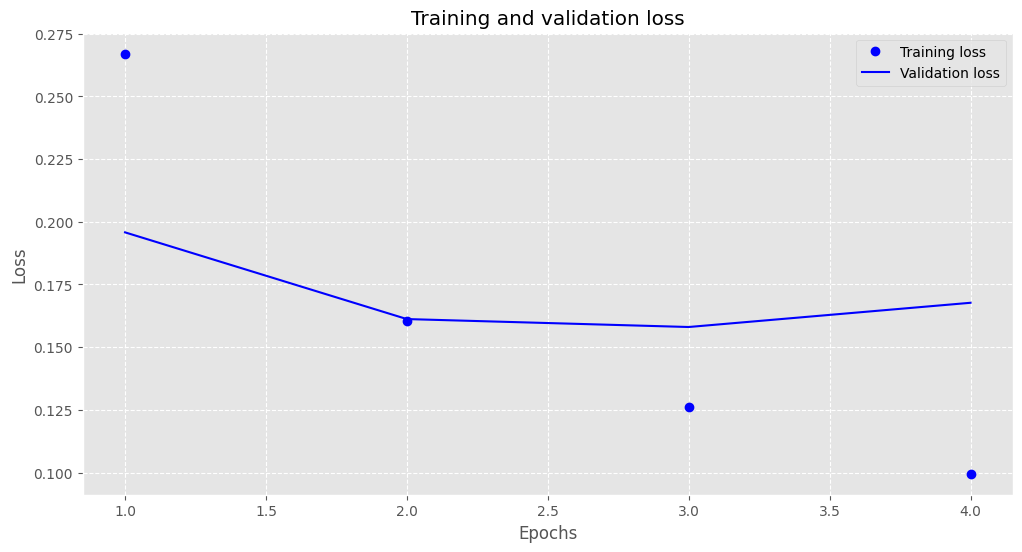

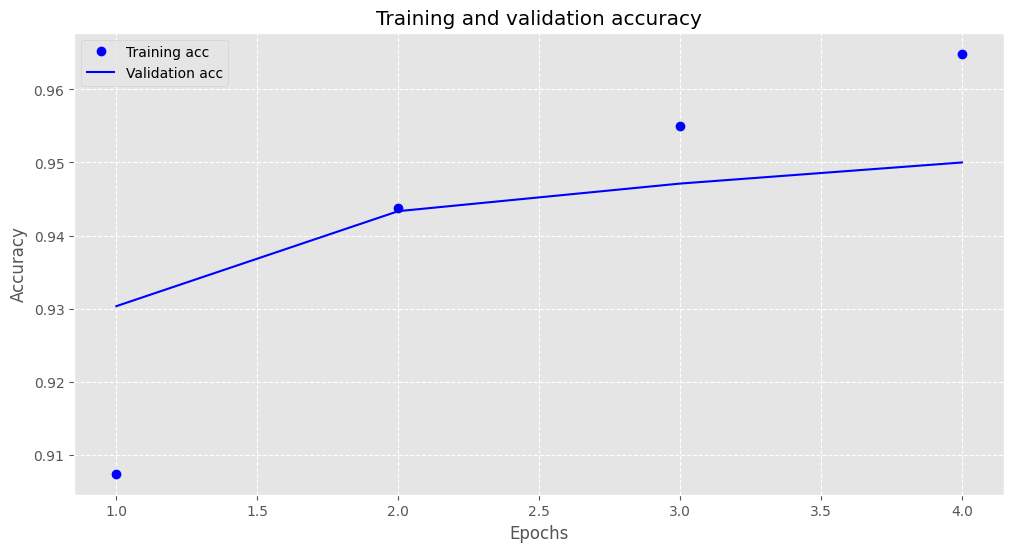

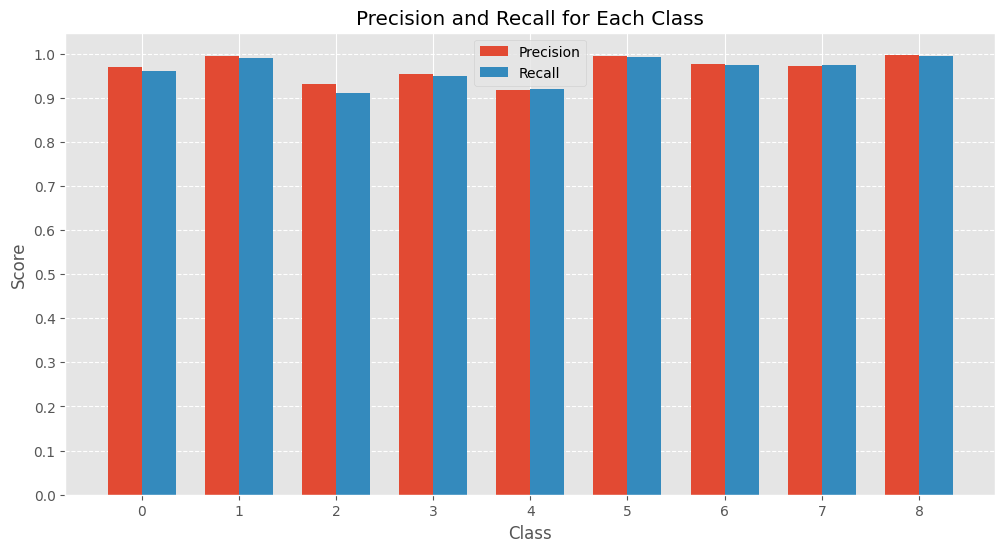

In [35]:
plot_history(history)
plot_precision_recall(history)